# CNN Factorio AI

In [40]:
import torch

print(torch.version.cuda)
# Check if CUDA GPU is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA not available. Training on CPU.")


12.8
CUDA is available. Training on GPU.


### Data processing

In [41]:
import numpy as np

import game
import importlib

importlib.reload(game)

from game import Board

def str_to_array(s):
    """Convert a string representation of a board to a numpy array."""
    lines = s.split("\n")[:-1]  # Remove the last empty line if it exists
    array = []
    for y, line in enumerate(lines):
        array.append([])
        for cell in line.split():
            array[y].append(int(cell))
    return array

# Parse the data
def parse_data(file):
    inputs = []
    outputs = []
    b = Board()

    index_board = ""
    with open(file,"r") as f:
        for i,line in enumerate(f):
            line = line.strip()
            if line.startswith("reward="):
                if index_board != "":
                    grid_array = str_to_array(index_board)
                    b.board_from_index(grid_array)
                    r = b.total_reward()
                    inputs.append(grid_array)
                    outputs.append(float(r))
                    b.reset()
                    index_board = ""
                reward = line.split("=")[1]
            else:
                index_board += line + "\n"
        grid_array = str_to_array(index_board)
        b.board_from_index(grid_array)
        r = b.total_reward()
        inputs.append(grid_array)
        outputs.append(float(r))
    return np.array(inputs), np.array(outputs).reshape(-1, 1)

X, y = parse_data("game.txt")
print(X.shape, y.shape)
print(max(y), min(y))

(100000, 5, 5) (100000, 1)
[6.9] [-1.25]


(array([8.989e+03, 9.939e+03, 9.218e+03, 6.327e+03, 3.066e+03, 1.220e+03,
        4.210e+02, 1.100e+02, 3.100e+01, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.210e+03, 6.314e+03, 8.451e+03, 7.489e+03, 4.532e+03, 2.787e+03,
        2.150e+02, 5.500e+01, 8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.527e+03, 4.086e+03, 4.952e+03, 3.926e+03, 2.155e+03, 9.250e+02,
        2.940e+02, 6.700e+01, 1.500e+01, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 7.520e+02, 1.933e+03, 3.680e+03, 7.090e+02, 3.100e+02,
        8.100e+01, 2.100e+01, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.020e+02, 7.040e+02, 6.340e+02, 4.800e+02, 2.050e+02,
        5.100e+01, 7.000e+00, 1.000e+0

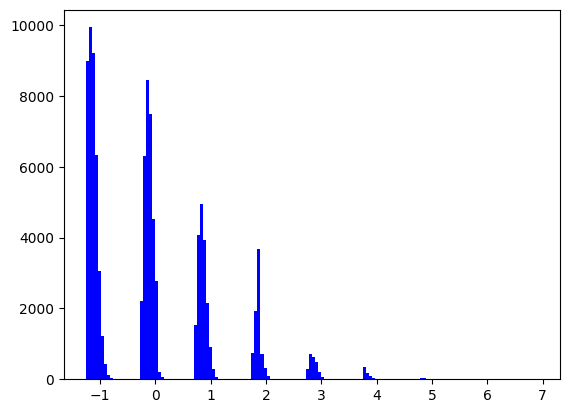

In [42]:
import matplotlib.pyplot as plt

plt.hist(y, bins=150, color='blue')

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from var import CELL_NUMBER

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_flat = X.reshape((X.shape[0], -1))

X_train , X_test, y_train,y_test = train_test_split(X_flat, y,test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_scaled = scaler_X.fit_transform(X_train).reshape(-1, CELL_NUMBER, CELL_NUMBER)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test).reshape(-1, CELL_NUMBER, CELL_NUMBER)
y_test_scaled = scaler_y.transform(y_test)

(80000, 25) (80000, 1) (20000, 25) (20000, 1)


In [44]:
from torch.utils.data import Dataset, DataLoader

class GridRewardDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 5, 5)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
ds_train = GridRewardDataset(X_train_scaled, y_train_scaled)
ds_test = GridRewardDataset(X_test_scaled, y_test_scaled)

train = DataLoader(ds_train, batch_size=32, shuffle=True,num_workers=27)
test = DataLoader(ds_test, batch_size=32,num_workers=27)

### Lightning Module

In [23]:
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

class RewardCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (B, 32, 5, 5)
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 5, 5)
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.AvgPool2d(kernel_size=2),                 # (B, 64, 2, 2)
    nn.Dropout(0.25),
    nn.Flatten(),                                # (B, 64*2*2)
    nn.Linear(64 * 2 * 2, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss,on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",          # metric to monitor
    mode="min",                  # minimize val_loss
    save_top_k=1,                # save only the best
    filename="best-checkpoint", # optional name
    verbose=True
)


early_stop_callback = EarlyStopping(
    monitor="val_loss",         # What to monitor
    patience=5,                 # Stop after 3 epochs without improvement
    verbose=True,
    mode="min"                  # Minimize the loss
)

model = RewardCNN()
trainer = pl.Trainer(max_epochs=100, callbacks=[checkpoint_callback,early_stop_callback],log_every_n_steps=1)
#trainer.fit(model, train,test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/matthieu/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


   epoch  train_loss  val_loss
0      0    0.017533  0.017297
1      1    0.017118  0.017264
2      2    0.016945  0.017365
3      3    0.016837  0.016770
4      4    0.016287  0.015694


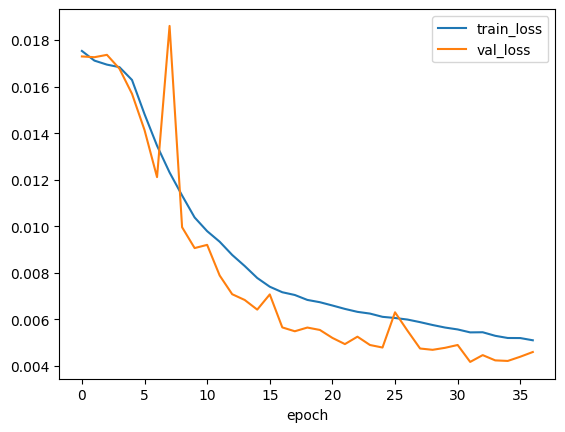

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("lightning_logs/version_0/metrics.csv")


df = df[df['train_loss'].notna() | df['val_loss'].notna()]
merged = df.groupby("epoch")[["train_loss", "val_loss"]].mean().reset_index()
print(merged.head(5))
merged.plot(x="epoch", y=["train_loss", "val_loss"])
plt.show()

[np.float32(0.2837394), np.float32(0.016534328), np.float32(0.094621636), np.float32(0.046745673), np.float32(0.24700922), np.float32(0.18051493), np.float32(0.10719383), np.float32(0.054958224), np.float32(0.4519127), np.float32(1.5542115), np.float32(0.039078884), np.float32(0.68344116), np.float32(0.14576042), np.float32(0.5014466), np.float32(0.06346687), np.float32(0.22322607), np.float32(0.53588504), np.float32(0.33962172), np.float32(0.23750007), np.float32(0.14043619), np.float32(0.28051466), np.float32(0.62038237), np.float32(0.3047008), np.float32(0.06216353), np.float32(0.66949224), np.float32(0.24881348), np.float32(0.032749712), np.float32(0.24764138), np.float32(0.15519565), np.float32(0.1479348), np.float32(0.79931927), np.float32(0.6827882), np.float32(0.61608654), np.float32(0.2588262), np.float32(0.043159246), np.float32(0.21035421), np.float32(0.14752913), np.float32(0.13057554), np.float32(0.4557348), np.float32(0.017823067), np.float32(0.17671424), np.float32(0.703

(array([4.112e+03, 3.401e+03, 2.486e+03, 1.957e+03, 1.562e+03, 1.163e+03,
        9.900e+02, 7.990e+02, 6.310e+02, 5.970e+02, 4.940e+02, 4.040e+02,
        2.860e+02, 1.840e+02, 1.430e+02, 1.060e+02, 8.600e+01, 8.100e+01,
        6.500e+01, 6.600e+01, 5.600e+01, 5.300e+01, 6.100e+01, 3.200e+01,
        3.900e+01, 2.500e+01, 2.100e+01, 1.100e+01, 1.200e+01, 6.000e+00,
        1.100e+01, 6.000e+00, 1.100e+01, 8.000e+00, 7.000e+00, 4.000e+00,
        6.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([6.50882721e-05, 7.85883442e-02, 1.57111600e-01, 2.35634863e-01,
        3.14158112e-01, 3.92681360e-01, 4.71204638e-01, 5.49727857e-01,
        6.28251135e-01, 7.06774414e-01, 7.85297632e-01, 8.63820910e-01,
        9.42344189e-01, 1.02086747e+00, 1.09939063e+00, 1.17791390e+00,
        1.25643718e+00, 1.33496046e+00, 1.41348374e+00, 1.49200690e+00,
        1.570530

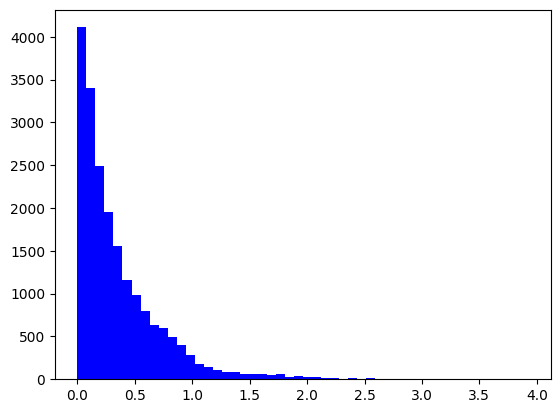

In [51]:
model = RewardCNN.load_from_checkpoint("lightning_logs/version_0/checkpoints/best-checkpoint.ckpt")
model.to("cuda")
model.eval()
error = []
with torch.no_grad():
    for i, (x, y_true) in enumerate(test):
        y_pred = model(x.to("cuda"))
        y_pred_denorm = scaler_y.inverse_transform(y_pred.cpu().numpy())
        y_true_denorm = scaler_y.inverse_transform(y_true.cpu().numpy())
        for yt, yp in zip(y_true_denorm, y_pred_denorm):
            error.append(np.abs(yp - yt)[0])

print(error)
print("Mean error:", np.mean(error))
print("Max error:", np.max(error))
print("Min error:", np.min(error))
print("Std error:", np.std(error))
plt.hist(error, bins=50, color='blue')

In [52]:
import numpy as np

import game
import importlib

importlib.reload(game)

from game import Board

import json

map_sym_int = json.load(open("sample.json", "r"))
def str_to_array(s):
    """Convert a string representation of a board to a numpy array."""
    lines = s.split("\n")[::2]  # Remove the last empty line if it exists
    lines = lines[:-1]
    array = []
    for y, line in enumerate(lines):
        array.append([])
        lines = line.strip()
        for cell in line.split():
            if cell.isdigit():
                array[y].append(int(cell))
            else:
                for item in map_sym_int:
                    if cell == item["str"]:
                        array[y].append(int(item['id']))
                        break
    return array

# Parse the data
def parse_data(file):
    inputs = []
    outputs = []
    b = Board()

    index_board = ""
    with open(file,"r") as f:
        for i,line in enumerate(f):
            if line == "\n":
                line = line.strip()
                grid_array = str_to_array(index_board)
                b.board_from_index(grid_array)
                r = b.total_reward()
                inputs.append(grid_array)
                outputs.append(float(r))
                b.reset()
                index_board = ""
            else:
                index_board += line + "\n"
    return np.array(inputs), np.array(outputs).reshape(-1, 1)

X, y = parse_data("test.txt")
print(X.shape, y.shape)
print(max(y), min(y))

(30, 5, 5) (30, 1)
[12.85] [-0.25]


(array([9., 0., 0., 3., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 3., 0., 0., 3.]),
 array([-2.5000e-01,  1.2000e-02,  2.7400e-01,  5.3600e-01,  7.9800e-01,
         1.0600e+00,  1.3220e+00,  1.5840e+00,  1.8460e+00,  2.1080e+00,
         2.3700e+00,  2.6320e+00,  2.8940e+00,  3.1560e+00,  3.4180e+00,
         3.6800e+00,  3.9420e+00,  4.2040e+00,  4.4660e+00,  4.7280e+00,
         4.9900e+00,  5.2520e+00,  5.5140e+00,  5.7760e+00,  6.0380e+00,
         6.3000e+00,  6.5620e+00,  6.8240e+00,  7.0860e+00,  7.3480e+00,
         7.6100e+00,  7.8720e+00,  8.1340e+00,  8.3960e+00,  8.6580e+00,
         8.9200e+00,  9.1820e+00,  9.4440e+00,  9.7060e+00,  9.9680e+00,
         1.0230e+01,  1.0492e+01,  1.0754e+01,  1.1016e+01,  1.1278e+01,
         1.1540e+01,  1.1802e+01,  1.2064e+01,  1.2326e+01,  1.2588e+01,
         1.2850e+01]),
 <BarContainer object

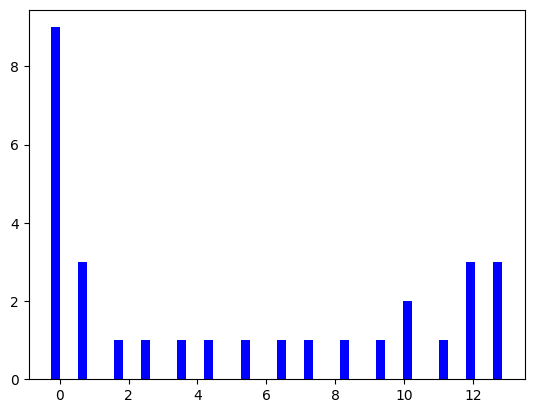

In [53]:
import matplotlib.pyplot as plt

plt.hist(y, bins=50, color='blue')

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from var import CELL_NUMBER

X_flat = X.reshape((X.shape[0], -1))

X_test_scaled = scaler_X.transform(X_flat).reshape(-1, CELL_NUMBER, CELL_NUMBER)
y_test_scaled = scaler_y.transform(y_test)

In [55]:
from torch.utils.data import Dataset, DataLoader

class GridRewardDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 5, 5)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
ds_test = GridRewardDataset(X_test_scaled, y_test_scaled)

test = DataLoader(ds_test, batch_size=32,num_workers=27)

[np.float32(1.5656197), np.float32(0.45801795), np.float32(0.6580859), np.float32(0.63123554), np.float32(1.5256059), np.float32(2.3492289), np.float32(0.821658), np.float32(1.3570224), np.float32(2.269815), np.float32(1.6608045), np.float32(2.1882956), np.float32(4.057208), np.float32(5.227539), np.float32(3.9355206), np.float32(5.557502), np.float32(3.4679716), np.float32(9.010261), np.float32(8.579734), np.float32(10.141353), np.float32(9.937259), np.float32(10.6637125), np.float32(10.390715), np.float32(10.991446), np.float32(8.85071), np.float32(8.891474), np.float32(0.5317603), np.float32(0.30845582), np.float32(0.39072382), np.float32(0.4273154), np.float32(1.3401005)]
Mean error: 4.272872
Max error: 10.991446
Min error: 0.30845582
Std error: 3.8288784


(array([4., 3., 1., 0., 2., 2., 1., 0., 1., 2., 0., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 1., 1., 1., 1.]),
 array([ 0.30845582,  0.52211565,  0.73577547,  0.94943523,  1.163095  ,
         1.37675488,  1.59041464,  1.80407453,  2.01773429,  2.23139405,
         2.44505405,  2.65871382,  2.87237358,  3.08603334,  3.29969311,
         3.51335287,  3.72701263,  3.9406724 ,  4.15433216,  4.3679924 ,
         4.58165216,  4.79531193,  5.00897169,  5.22263145,  5.43629122,
         5.64995098,  5.86361074,  6.07727098,  6.29093075,  6.50459051,
         6.71825027,  6.93191004,  7.1455698 ,  7.35922956,  7.57288933,
         7.78654909,  8.00020885,  8.21386814,  8.42752838,  8.64118767,
         8.85484791,  9.06850719,  9.28216743,  9.49582767,  9.70948696,
         9.9231472 , 10.13680649, 10.35046673, 10.56412601, 10.77778625,
        10.99144554]),
 <BarContainer object

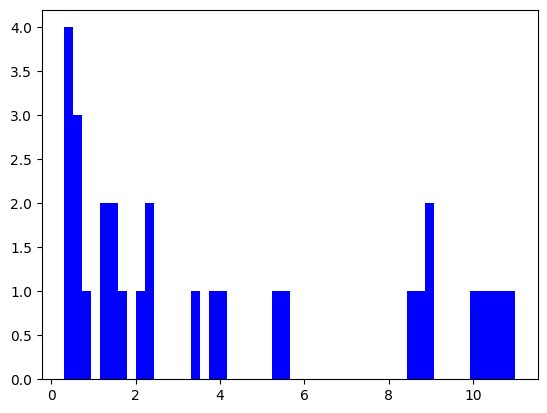

In [57]:
model.eval()
error = []
with torch.no_grad():
    for i, (x, y_true) in enumerate(test):
        y_pred = model(x.to("cuda"))
        y_pred_denorm = scaler_y.inverse_transform(y_pred.cpu().numpy())
        y_true_denorm = scaler_y.inverse_transform(y_true.cpu().numpy())
        for yt, yp in zip(y_true_denorm, y_pred_denorm):
            error.append(np.abs(yp - yt)[0])

print(error)
print("Mean error:", np.mean(error))
print("Max error:", np.max(error))
print("Min error:", np.min(error))
print("Std error:", np.std(error))
plt.hist(error, bins=50, color='blue')